In [1]:
import torch
from torch import nn
from torchvision import models
from torchvision import transforms
from torch import optim
from PIL import Image
import os
import torch.nn as nn
from torch.autograd import Variable

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [8]:
data = pd.read_pickle("dataframe_aug.pkl")
data.head()

,folder,image,Emotion,Labels
0,./KDEF_and_AKDEF/sorted_set/happy,Gauss_BF30HAFL.JPG,happy,3
1,./KDEF_and_AKDEF/sorted_set/surprise,AF16SUS.JPG,surprise,6
2,./KDEF_and_AKDEF/sorted_set/fear,Gauss_AM14AFFR.JPG,fear,2
3,./KDEF_and_AKDEF/sorted_set/disgust,BF26DIHR.JPG,disgust,1
4,./KDEF_and_AKDEF/sorted_set/fear,BF07AFS.JPG,fear,2


In [9]:
num_classes = 7

In [10]:
data_train, data_test = train_test_split(data, stratify=data["Labels"], test_size = 0.2, random_state=1)
data_train, data_cv = train_test_split(data_train, stratify=data_train["Labels"], test_size = 0.2, random_state=1)
data_train.shape, data_cv.shape, data_test.shape

((6268, 4), (1568, 4), (1960, 4))

In [7]:
# data_train=data_train[:320]
# data_cv = data_cv[:70]
# data_train.shape, data_cv.shape

In [11]:
class new_model(nn.Module):
    def __init__(self):
        super(new_model, self).__init__()
        self.features = nn.Sequential(*list(vgg.features.children()))
        input_dim = 10*10*512
        self.fc1 = nn.Sequential(nn.Linear(input_dim, 512), nn.ReLU(), nn.Dropout(0.5))
        self.fc2 = nn.Sequential(nn.Linear(512, 256), nn.ReLU(), nn.BatchNorm1d(256), nn.Dropout(0.5))
        self.fc3 = nn.Sequential(nn.Linear(256, 128), nn.ReLU(), nn.BatchNorm1d(128), nn.Dropout(0.5))
        self.fc4 = nn.Sequential(nn.Linear(128, 64), nn.ReLU(), nn.BatchNorm1d(64), nn.Dropout(0.5))
        self.fc5 = nn.Sequential(nn.Linear(64, num_classes))
        
    def forward(self, x):
        out = self.features(x)
        out = out.reshape(out.shape[0], -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.fc4(out)
        out = self.fc5(out)
        return out

In [12]:
train_labels = np.array(data_train["Labels"])
test_labels = np.array(data_test["Labels"])
cv_labels = np.array(data_cv["Labels"])

In [13]:
def get_batch_Train(batch_size):
    global pointer_train
    images_batch = []
    labels_batch = []
    for i in range(batch_size):
        path1 = data_train.iloc[pointer_train + i]["folder"]
        path2 = data_train.iloc[pointer_train + i]["image"]
        image = Image.open(os.path.join(path1, path2))
        image=np.array(image).transpose(2,0,1)
        image_norm = image/255.0
        images_batch.append(image_norm)
        
        labels_batch.append(train_labels[pointer_train + i])
        
    pointer_train += batch_size
        
    return np.array(images_batch), np.array(labels_batch)

In [14]:
def get_batch_Test(batch_size):
    global pointer_test
    images_batch = []
    labels_batch = []
    for i in range(batch_size):
        path1 = data_test.iloc[pointer_test + i]["folder"]
        path2 = data_test.iloc[pointer_test + i]["image"]
        image = Image.open(os.path.join(path1, path2))
        image=np.array(image).transpose(2,0,1)
        image_norm = image/255.0
        images_batch.append(image_norm)
        
        labels_batch.append(test_labels[pointer_test + i])
        
    pointer_test += batch_size
        
    return np.array(images_batch), np.array(labels_batch)

In [15]:
def get_batch_cv(batch_size):
    global pointer_cv
    images_batch = []
    labels_batch = []
    for i in range(batch_size):
        path1 = data_cv.iloc[pointer_cv + i]["folder"]
        path2 = data_cv.iloc[pointer_cv + i]["image"]
        image = Image.open(os.path.join(path1, path2))
        image=np.array(image).transpose(2,0,1)
        image_norm = image/255.0
        images_batch.append(image_norm)
        
        labels_batch.append(cv_labels[pointer_cv + i])
        
    pointer_cv += batch_size
        
    return np.array(images_batch), np.array(labels_batch)

In [16]:
def train (input_image,target):
    FEN.train()
    optimizer.zero_grad()
    prob=FEN(input_image)
    loss=criterion(prob,target)
    loss.backward()
    optimizer.step()
    return loss.item()

In [17]:
def validate (input_image,target):
    with torch.no_grad():
        FEN.eval()
        prob=FEN(input_image)
        loss=criterion(prob,target)
        return loss.item()

In [18]:
vgg = models.vgg16(pretrained=True).to(device)
FEN = new_model().to(device)
for param in FEN.features.parameters():
    param.requires_grad = False

In [19]:
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(FEN.parameters())
optimizer = torch.optim.Adam(
    [
        {"params": FEN.features.parameters(), "lr": 1e-5},
        {"params": FEN.fc1.parameters()},
        {"params": FEN.fc2.parameters()},
        {"params": FEN.fc3.parameters()},
        {"params": FEN.fc4.parameters()},
        {"params": FEN.fc5.parameters()},
    ],
    lr=1e-3,
)

In [20]:
train_loss=[]
validation_loss=[]
epochs = 30
batch_size = 16
global_loss=1.0
train_images = int(len(data_train) / batch_size)
cv_images = int(len(data_cv) / batch_size)
for epoch in range(epochs):
    if epoch == 10:
        for p in FEN.parameters():
            p.requires_grad = True
    pointer_train = 0
    pointer_test = 0
    pointer_cv = 0

    running_loss = 0
#     if (epoch+1)%10 == 0:
#         for g in optimizer.param_groups:
#             g['lr']/=2
    for i in range(train_images):
        X_train, y_train = get_batch_Train(batch_size)
        X_train = Variable(torch.tensor(X_train)).to(device).float()
        y_train = Variable(torch.tensor(y_train)).to(device)
        loss=train(X_train,y_train)
        running_loss+=loss
    #Validation
    loss_val=0
    for j in range(cv_images):
        X_cv, y_cv = get_batch_cv(batch_size)
        X_cv = Variable(torch.tensor(X_cv)).to(device).float()
        y_cv = Variable(torch.tensor(y_cv)).to(device)
        loss_val+=validate(X_cv,y_cv)
    loss_val=loss_val/(j+1)
    validation_loss.append(loss_val)
    running_loss = running_loss/(i+1)
    train_loss.append(running_loss)
    print ('Epoch: {} | Training loss: {} | Validation Loss: {}'.format(epoch+1, running_loss, loss_val))
    if(global_loss > loss_val):
        global_loss = loss_val
        torch.save(FEN.state_dict(), './saved_models/VGG-Adam-LR-3-5-Aug.pth')
        print("Model saved at epoch: {}".format(epoch+1))
                   
    #print ('Epoch: {} | Training loss: {}'.format(epoch+1, running_loss))

    

Epoch: 1 | Training loss: 1.980918901350797 | Validation Loss: 1.9160080637250627
Epoch: 2 | Training loss: 1.8891967300258938 | Validation Loss: 1.7525111546321792
Epoch: 3 | Training loss: 1.726909536534868 | Validation Loss: 1.5443805066906675
Epoch: 4 | Training loss: 1.541768353003675 | Validation Loss: 1.3150366477820339
Epoch: 5 | Training loss: 1.3647454487698158 | Validation Loss: 1.2102184909947065
Epoch: 6 | Training loss: 1.2063268894124823 | Validation Loss: 1.0471632121777048
Epoch: 7 | Training loss: 1.0784872716954907 | Validation Loss: 0.9386450569240414
Model saved at epoch: 7
Epoch: 8 | Training loss: 0.9940859192167707 | Validation Loss: 0.8818708673423651
Model saved at epoch: 8
Epoch: 9 | Training loss: 0.8968986214884102 | Validation Loss: 0.8659736161329308
Model saved at epoch: 9
Epoch: 10 | Training loss: 0.8166691995490237 | Validation Loss: 0.8398103038875424
Model saved at epoch: 10
Epoch: 11 | Training loss: 0.7268459639890724 | Validation Loss: 0.67855908

In [26]:
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
def print_confusionMatrix(Y_TestLabels, PredictedLabels):
    confusionMatx = confusion_matrix(Y_TestLabels, PredictedLabels)
    
    precision = confusionMatx/confusionMatx.sum(axis = 0)
    
    recall = (confusionMatx.T/confusionMatx.sum(axis = 1)).T
    
    sns.set(font_scale=1.5)
    
    
    labels = ["ANGRY", "DISGUST", "FEAR", "HAPPY", "NEUTRAL", "SAD", "SURPRISE"]
    
    plt.figure(figsize=(16,7))
    sns.heatmap(confusionMatx, cmap = "Blues", annot = True, fmt = ".1f", xticklabels=labels, yticklabels=labels)
    plt.title("Confusion Matrix", fontsize = 30)
    plt.xlabel('Predicted Class', fontsize = 20)
    plt.ylabel('Original Class', fontsize = 20)
    plt.tick_params(labelsize = 15)
    plt.xticks(rotation = 90)
    plt.show()
    
    plt.figure(figsize=(16,7))
    sns.heatmap(precision, cmap = "Blues", annot = True, fmt = ".2f", xticklabels=labels, yticklabels=labels)
    plt.title("Precision Matrix", fontsize = 30)
    plt.xlabel('Predicted Class', fontsize = 20)
    plt.ylabel('Original Class', fontsize = 20)
    plt.tick_params(labelsize = 15)
    plt.xticks(rotation = 90)
    plt.show()
    
    
    plt.figure(figsize=(16,7))
    sns.heatmap(recall, cmap = "Blues", annot = True, fmt = ".2f", xticklabels=labels, yticklabels=labels)
    plt.title("Recall Matrix", fontsize = 30)
    plt.xlabel('Predicted Class', fontsize = 20)
    plt.ylabel('Original Class', fontsize = 20)
    plt.tick_params(labelsize = 15)
    plt.xticks(rotation = 90)
    plt.show()

In [27]:
FEN.load_state_dict(torch.load('./saved_models/VGG-Adam-LR-3-5-Aug.pth'))
FEN.eval()

new_model(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): 

In [28]:
test_images = len(data_test)
predicted_labels=[]
true_labels=[]
pointer_test = 0
for i in range(test_images):
    X_test, y_test = get_batch_Test(1)
    
    X_test = Variable(torch.tensor(X_test)).to(device).float()
    X_test.unsqueeze(0)
    pred=FEN(X_test)
    predicted_labels.append(pred.argmax().item())
    true_labels.append(y_test[0])
acc = accuracy_score(true_labels, predicted_labels)
print("Accuracy on Human Test Data = {}%".format(np.round(float(acc*100), 2)))

Accuracy on Human Test Data = 87.14%


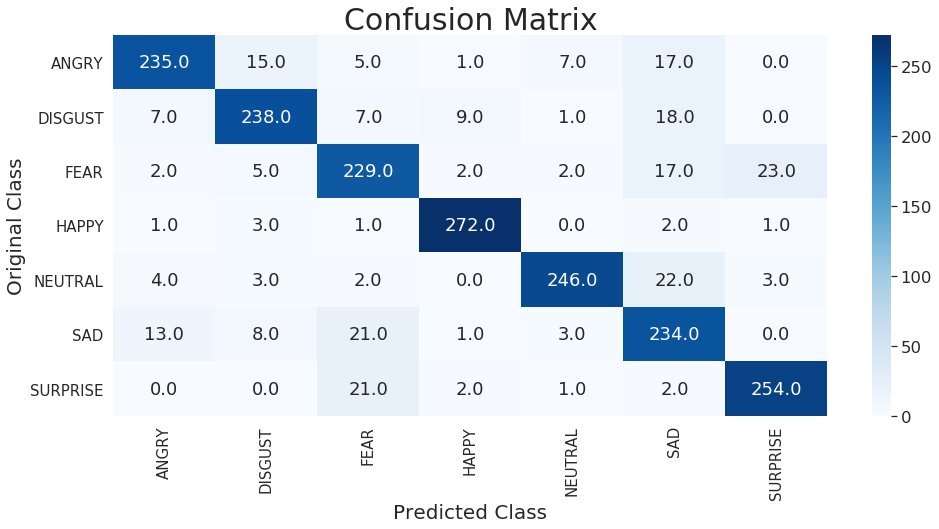

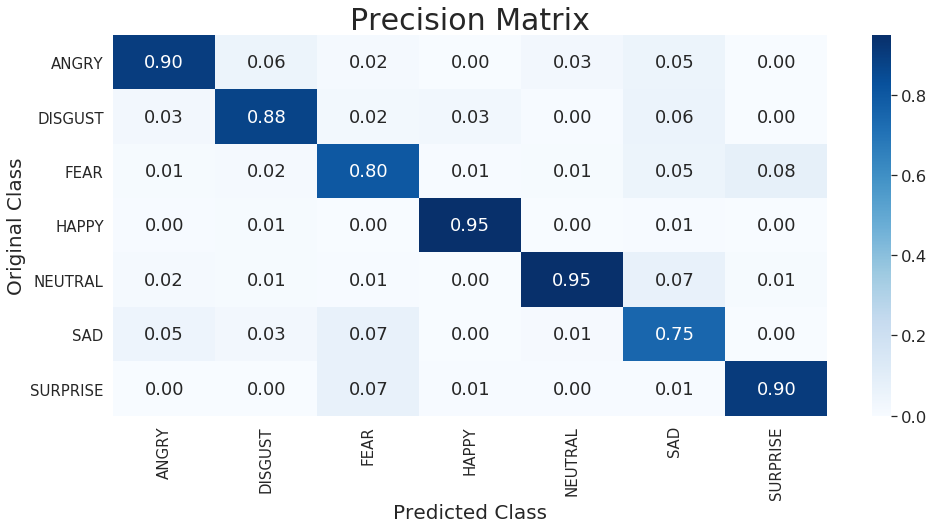

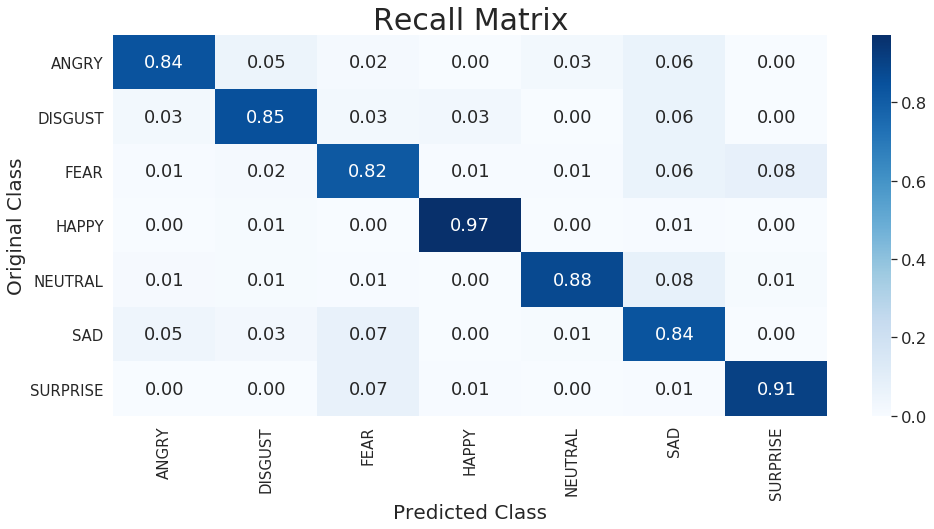

In [29]:
print_confusionMatrix(true_labels, predicted_labels)

In [30]:
emotions = {1:"ANGRY", 2:"DISGUST", 3:"FEAR", 4:"HAPPY", 5:"NEUTRAL", 6:"SAD", 7:"SURPRISE"}
def pridict_real_image(img_path):
    image = Image.open(img_path)
    image=np.array(image).transpose(2,0,1)
    image_norm = image/255.0
    X_test = Variable(torch.tensor(image_norm)).to(device).float()
    X_test = X_test.unsqueeze(0)
    pred=FEN(X_test)
    label = pred.argmax().item() + 1
    print("Predicted Facial Expression Probabilities")
    print("ANGRY: {}\nDISGUST: {}\nFEAR: {}\nHAPPY: {}\nNEUTRAL: {}\nSAD: {}\nSURPRISE: {}\n\n".format(pred[0][0].item(), pred[0][1].item(), pred[0][2].item(),pred[0][3].item(), pred[0][4].item(), pred[0][5].item(), pred[0][6].item()))
    print("Dominant Probability = "+str(emotions[label]))
    

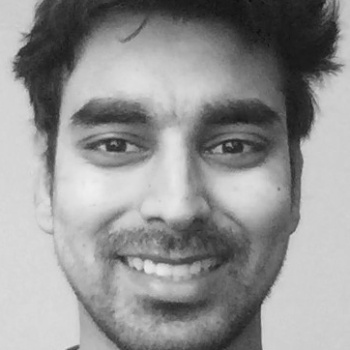

In [31]:
Image.open('happy.jpg')

In [32]:
pridict_real_image('happy.jpg')

Predicted Facial Expression Probabilities
ANGRY: -2.662997245788574
DISGUST: 0.5125606060028076
FEAR: -0.646307110786438
HAPPY: 5.774384021759033
NEUTRAL: 0.7348749041557312
SAD: 0.7472836971282959
SURPRISE: -2.1563031673431396


Dominant Probability = HAPPY


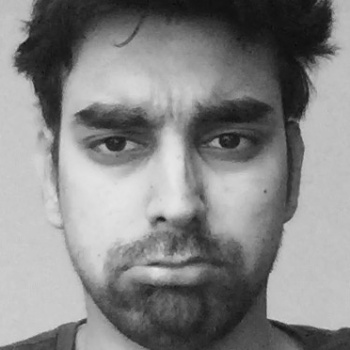

In [33]:
Image.open('sad.jpg')

In [34]:
pridict_real_image('sad.jpg')

Predicted Facial Expression Probabilities
ANGRY: 2.525461196899414
DISGUST: -0.1120574101805687
FEAR: 0.5595787763595581
HAPPY: -4.23092794418335
NEUTRAL: -0.4304683804512024
SAD: 4.431809902191162
SURPRISE: -3.7970311641693115


Dominant Probability = SAD


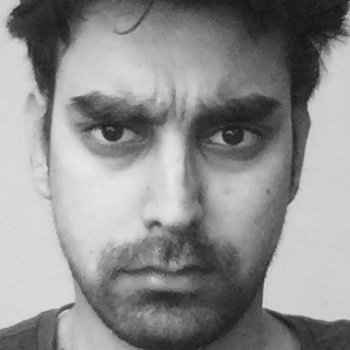

In [35]:
Image.open('angry.jpg')

In [36]:
pridict_real_image('angry.jpg')

Predicted Facial Expression Probabilities
ANGRY: 4.612221717834473
DISGUST: 0.39728468656539917
FEAR: 0.5237134099006653
HAPPY: -4.422097682952881
NEUTRAL: -0.7702167630195618
SAD: 2.904728889465332
SURPRISE: -3.102935552597046


Dominant Probability = ANGRY


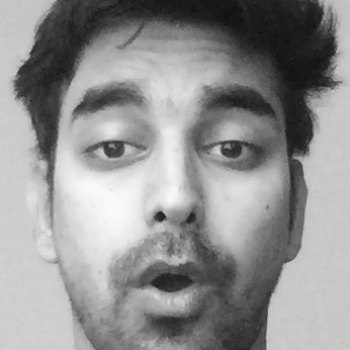

In [37]:
Image.open('surprise.jpg')

In [38]:
pridict_real_image('surprise.jpg')

Predicted Facial Expression Probabilities
ANGRY: -1.9272644519805908
DISGUST: -2.0075011253356934
FEAR: 5.937451362609863
HAPPY: -3.018230438232422
NEUTRAL: -3.009746551513672
SAD: -0.822990894317627
SURPRISE: 1.9900801181793213


Dominant Probability = FEAR


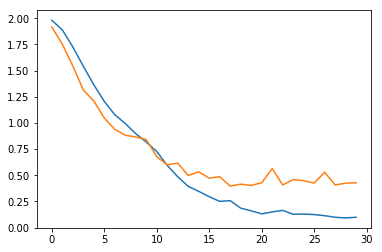

In [25]:
# VGG16 - LR- 1e-5, VGG - LR - 1e-3, Adam, AUG
import matplotlib.pyplot as plt
plt.plot(np.arange(0, epoch+1), train_loss)
plt.plot(np.arange(0, epoch+1), validation_loss)